# Predicting Appointment No Shows in 2016
## Rachel Holman, Ben Nikolai, Reanna Panagides

On our honor, we pledge that we have neither given nor recieved help on this assignment

### Motivation:
When a patient “No Show’s” on a medical appointment, there are can be many negative consequences such as the resources/time are wasted on the scheduling process, along with delayed medical care, possibly impacting health.

### Goals:
Our goals for this project are to 1) Describe the uncertainty in “No Show” outcomes given specific demographic and medical information about a patient; 2) Evaluate the posterior probability distributions of the regression parameters for the predictor variables obtained from patients; and 3) Evaluate the model predictions and uncertainties in these predictions.

### Data:
The data can be found on kaggle:
https://www.kaggle.com/datasets/raniahelmy/no-show-investigate-dataset/

### Approach:
We propose to use Bayesian logistic regression with Hamiltonian Monte Carlo and/or Hierarchical modeling based on neighborhood and will investigate:

1) a main effects model

2) a simpler model

3) a Bayesian model averaging approach if time permits


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
import scipy as sp
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import animation
from patsy import bs, dmatrix
from cycler import cycler
from scipy import special, stats
from sklearn.metrics import RocCurveDisplay, accuracy_score, auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [2]:
az.style.use('arviz-darkgrid')
#plt.rcParams['figure.dpi'] = 300

random_seed = 730612
cores = 4

In [3]:
# discuss the business understanding

Data Dictionary:
    
- **PatientId:** Identification of a patient
- **AppointmentID:** Identification of each appointment
- **Gender:** Male or Female. (M/F)
- **ScheduledDay:** is the day someone called or registered the appointment, this is before appointment
- **Appointment day:** is the day of the actual appointment
- **Age:** How old is the patient.
- **Neighbourhood:** Where the appointment takes place.
- **Scholarship:** True of False. (0/1)
- **Hipertension:** True or False. (0/1)
- **Diabetes:** True or False. (0/1)
- **Alcoholism:** True or False. (0/1)
- **Handcap:** Level of Handicap Status (0-4)
- **SMS_received:** 1 or more messages sent to the patient.
- **No-show:** True or False. (Yes/No)

In [4]:
# Loading the data (ensure you saved this dataset to the same folder as this code)

noshow = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")
noshow

PatientId  AppointmentID Gender          ScheduledDay  \
0       2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1       5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2       4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3       8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4       8.841186e+12        5642494      F  2016-04-29T16:07:23Z   
...              ...            ...    ...                   ...   
110522  2.572134e+12        5651768      F  2016-05-03T09:15:35Z   
110523  3.596266e+12        5650093      F  2016-05-03T07:27:33Z   
110524  1.557663e+13        5630692      F  2016-04-27T16:03:52Z   
110525  9.213493e+13        5630323      F  2016-04-27T15:09:23Z   
110526  3.775115e+14        5629448      F  2016-04-27T13:30:56Z   

              AppointmentDay  Age      Neighbourhood  Scholarship  \
0       2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0   
1       2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0   
2       2016-04-29T00:00:00Z   62      MATA DA PRAIA            0   
3       2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0   
4       2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0   
...                      ...  ...                ...          ...   
110522  2016-06-07T00:00:00Z   56        MARIA ORTIZ            0   
110523  2016-06-07T00:00:00Z   51        MARIA ORTIZ            0   
110524  2016-06-07T00:00:00Z   21        MARIA ORTIZ            0   
110525  2016-06-07T00:00:00Z   38        MARIA ORTIZ            0   
110526  2016-06-07T00:00:00Z   54        MARIA ORTIZ            0   

        Hipertension  Diabetes  Alcoholism  Handcap  SMS_received No-show  
0                  1         0           0        0             0      No  
1                  0         0           0        0             0      No  
2                  0         0           0        0             0      No  
3                  0         0           0        0             0      No  
4                  1         1           0        0             0      No  
...              ...       ...         ...      ...           ...     ...  
110522             0         0           0        0             1      No  
110523             0         0           0        0             1      No  
110524             0         0           0        0             1      No  
110525             0         0           0        0             1      No  
110526             0         0           0        0             1      No  

[110527 rows x 14 columns]

# EDA

In [5]:
noshow.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [6]:

# changing header spellings
noshow = noshow.rename(columns={'Hipertension': 'Hypertension',
                                'Handcap': 'Handicap',
                                'SMS_received': 'SMSReceived',
                                'No-show':'Noshow',
                                'Neighbourhood':'Neighborhood'})
noshow.head()

PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age       Neighborhood  Scholarship  Hypertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handicap  SMSReceived Noshow  
0         0           0         0            0     No  
1         0           0         0            0     No  
2         0           0         0            0     No  
3         0           0         0            0     No  
4         1           0         0            0     No

In [7]:
noshow.describe()

# we notice handicap (a 0/1 variable) has a max value of 4...
# we should explore this more.. maybe the data dict is wrong and
# it is meant to represent level of handicap?

# should we drop columns with negative or missing age?

PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205       0.297675   
min    3.921784e+04   5.030230e+06      -1.000000       0.000000   
25%    4.172614e+12   5.640286e+06      18.000000       0.000000   
50%    3.173184e+13   5.680573e+06      37.000000       0.000000   
75%    9.439172e+13   5.725524e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hypertension       Diabetes     Alcoholism       Handicap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       4.000000   

         SMSReceived  
count  110527.000000  
mean        0.321026  
std         0.466873  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

In [8]:
# check the number of unique values per variable

noshow.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighborhood          81
Scholarship            2
Hypertension           2
Diabetes               2
Alcoholism             2
Handicap               5
SMSReceived            2
Noshow                 2
dtype: int64

### It's important to note:

- some patients repeat.

- there is a signficant difference in the number of schedule and appointment days. Part of the reason is probably because the schedule days have timestamps, while all appointment days are set at 00:00:00.

- 'Handcap' has 5 unique values unlike the other patient characteristics which only have 2.

In [9]:
# Show And No-Show patient distribution
# Yes= No-show # No = Show

noshow['Noshow'].value_counts()

Noshow
No     88208
Yes    22319
Name: count, dtype: int64

In [10]:
# pivot table with gender and Noshow column
noshow_fm = noshow.groupby(['Noshow','Gender'],as_index=False).size()
ns_pivot = pd.pivot_table(noshow_fm, values = 'size',columns=['Noshow'],index='Gender')
ns_pivot

Noshow     No    Yes
Gender              
F       57246  14594
M       30962   7725

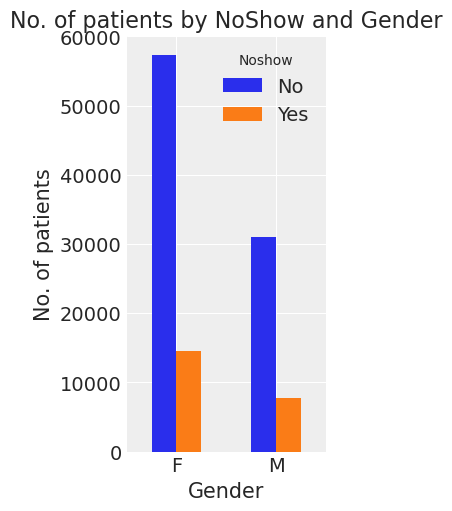

In [11]:
# Visualizing the pivot table
ax = ns_pivot.plot(
        kind='bar',
        title = 'No. of patients by NoShow and Gender',
        figsize=(3, 5),
        rot=0)
ax.set_xlabel('Gender')
ax.set_ylabel('No. of patients');

In [12]:
# Changing scheduled_day and appointment_day to DateTime
noshow.AppointmentDay = pd.to_datetime(noshow.AppointmentDay)
noshow.ScheduledDay = pd.to_datetime(noshow.ScheduledDay)

noshow.head()

PatientId  AppointmentID Gender              ScheduledDay  \
0  2.987250e+13        5642903      F 2016-04-29 18:38:08+00:00   
1  5.589978e+14        5642503      M 2016-04-29 16:08:27+00:00   
2  4.262962e+12        5642549      F 2016-04-29 16:19:04+00:00   
3  8.679512e+11        5642828      F 2016-04-29 17:29:31+00:00   
4  8.841186e+12        5642494      F 2016-04-29 16:07:23+00:00   

             AppointmentDay  Age       Neighborhood  Scholarship  \
0 2016-04-29 00:00:00+00:00   62    JARDIM DA PENHA            0   
1 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   
2 2016-04-29 00:00:00+00:00   62      MATA DA PRAIA            0   
3 2016-04-29 00:00:00+00:00    8  PONTAL DE CAMBURI            0   
4 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   

   Hypertension  Diabetes  Alcoholism  Handicap  SMSReceived Noshow  
0             1         0           0         0            0     No  
1             0         0           0         0            0     No  
2             0         0           0         0            0     No  
3             0         0           0         0            0     No  
4             1         1           0         0            0     No

In [13]:
# create new column for the day of the week for appointments
noshow['app_weekday'] = noshow['AppointmentDay'].dt.dayofweek
noshow['app_weekday'].value_counts()

# 0=monday and so on

app_weekday
2    25867
1    25640
0    22715
4    19019
3    17247
5       39
Name: count, dtype: int64

In [14]:
# Create a column for the difference between scheduled an appointment
noshow['days_between'] = (noshow.AppointmentDay-noshow.ScheduledDay).dt.days
noshow.head()

PatientId  AppointmentID Gender              ScheduledDay  \
0  2.987250e+13        5642903      F 2016-04-29 18:38:08+00:00   
1  5.589978e+14        5642503      M 2016-04-29 16:08:27+00:00   
2  4.262962e+12        5642549      F 2016-04-29 16:19:04+00:00   
3  8.679512e+11        5642828      F 2016-04-29 17:29:31+00:00   
4  8.841186e+12        5642494      F 2016-04-29 16:07:23+00:00   

             AppointmentDay  Age       Neighborhood  Scholarship  \
0 2016-04-29 00:00:00+00:00   62    JARDIM DA PENHA            0   
1 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   
2 2016-04-29 00:00:00+00:00   62      MATA DA PRAIA            0   
3 2016-04-29 00:00:00+00:00    8  PONTAL DE CAMBURI            0   
4 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   

   Hypertension  Diabetes  Alcoholism  Handicap  SMSReceived Noshow  \
0             1         0           0         0            0     No   
1             0         0           0         0            0     No   
2             0         0           0         0            0     No   
3             0         0           0         0            0     No   
4             1         1           0         0            0     No   

   app_weekday  days_between  
0            4            -1  
1            4            -1  
2            4            -1  
3            4            -1  
4            4            -1

In [15]:
noshow["days_between"] = np.where(noshow["days_between"] < 0, 0, noshow["days_between"])
noshow.days_between.unique()

array([  0,   1,   2,   3,   8,  28,   9,  22,  10,  17,  16,  13,  27,
        23,  20,  14,  15,  21,  42,  29,  30,  41,  31,  55,  44,  45,
        38,  36,  37,  43,  49,  59,  51,  52,  64,  66,  90,  65,  83,
        77,  86, 114, 108,  62,  69,  71,  56,  57,  50,  58,  40,  48,
        72,  63,  19,  32,  33,   5,  34,  35,  11,  12,  39,  46,   7,
         4,   6,  24,  25,  47,  26,  18,  60,  54,  61, 175,  53,  76,
        68,  82,  75,  88,  80, 102,  78,  67,  74,  84, 111,  79,  85,
        97,  93, 141, 154, 161, 168, 103, 132, 124,  95,  87,  89, 150,
       125, 126, 110, 118,  73,  70,  81, 107, 109, 101, 121, 100, 104,
        91,  96,  92, 106,  94, 138, 131, 178, 116, 145, 122])

<Axes: >

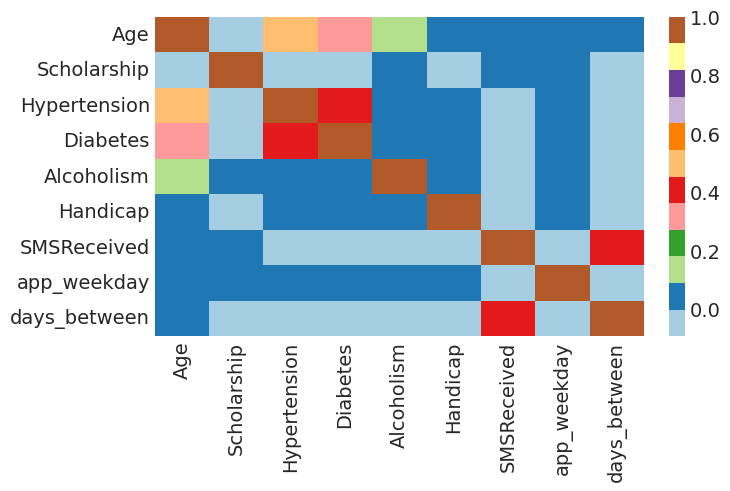

In [16]:
temp = noshow[['Age', 'Scholarship', 'Hypertension', 
                     'Diabetes', 'Alcoholism', 'Handicap', 'SMSReceived', 
                     'app_weekday', 'days_between']]
sns.heatmap(temp.corr(), cmap="Paired")

### Note:

Age and hypertension seem quite positively correlated. Hypertention and diabetes are also quite positively correlated.

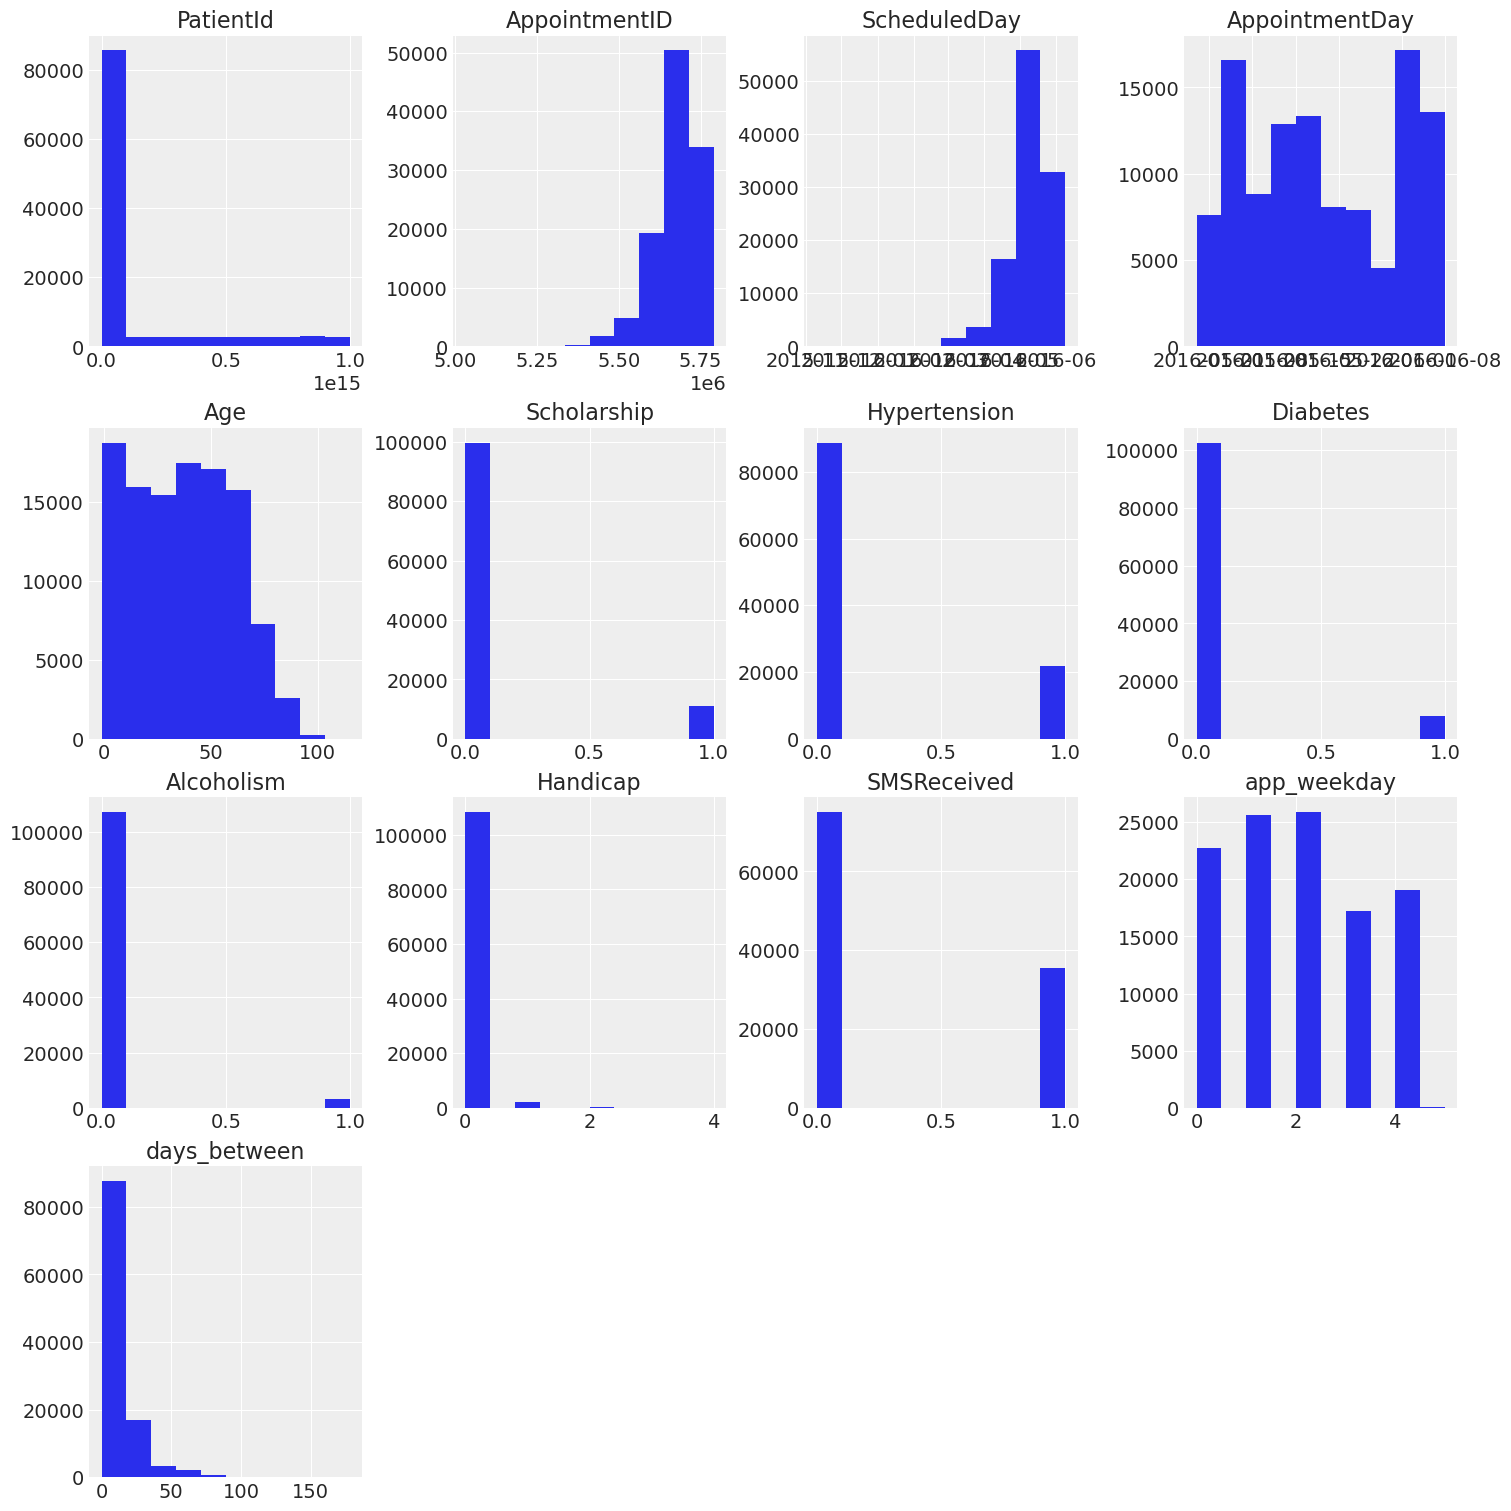

In [17]:
# Draw histogram for the different variables
noshow.hist(figsize=(15,15));

# Preprocessing of the Data

In [18]:
#predictors = noshow[['Scholarship', 'Age']]


#replacing Neighbourhoods with integers instead of strings
mn_hoods = noshow['Neighborhood'].unique()
n_hoods = len(mn_hoods)
hood_lookup = dict(zip(mn_hoods, range(n_hoods)))
hoods = noshow['Neighborhood'].replace(hood_lookup).values

# Changing patient_id to integer
noshow.PatientId = noshow.PatientId.astype('int64')

#replacing gender to binary
replace_gender = {"M":0, "F":1}
noshow['Gender'] = noshow['Gender'].replace(replace_gender)

#replacing y variable to binary outcome
replace_NoShow = {"No": 0, "Yes": 1}
noshow['Noshow'] = noshow['Noshow'].replace(replace_NoShow)

#scaling Age
noshow['ScaledAge'] = preprocessing.scale(noshow["Age"])

#transformation of days_between variable
noshow['days_between_log'] = np.log(noshow['days_between'] + 1)

#dataset of only predictors
predictors = noshow[['ScaledAge', 'Gender', 'Scholarship', 'Hypertension', 
                     'Diabetes', 'Alcoholism', 'Handicap', 'SMSReceived', 
                     'app_weekday', 'days_between', "days_between_log"]]

In [19]:
#creating a testing/training split to evalute
from sklearn.model_selection import train_test_split

# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(predictors, noshow['Noshow'],
                                   random_state=104,
                                   test_size=0.25,
                                   shuffle=True)

# Creating our Model

## Full Model


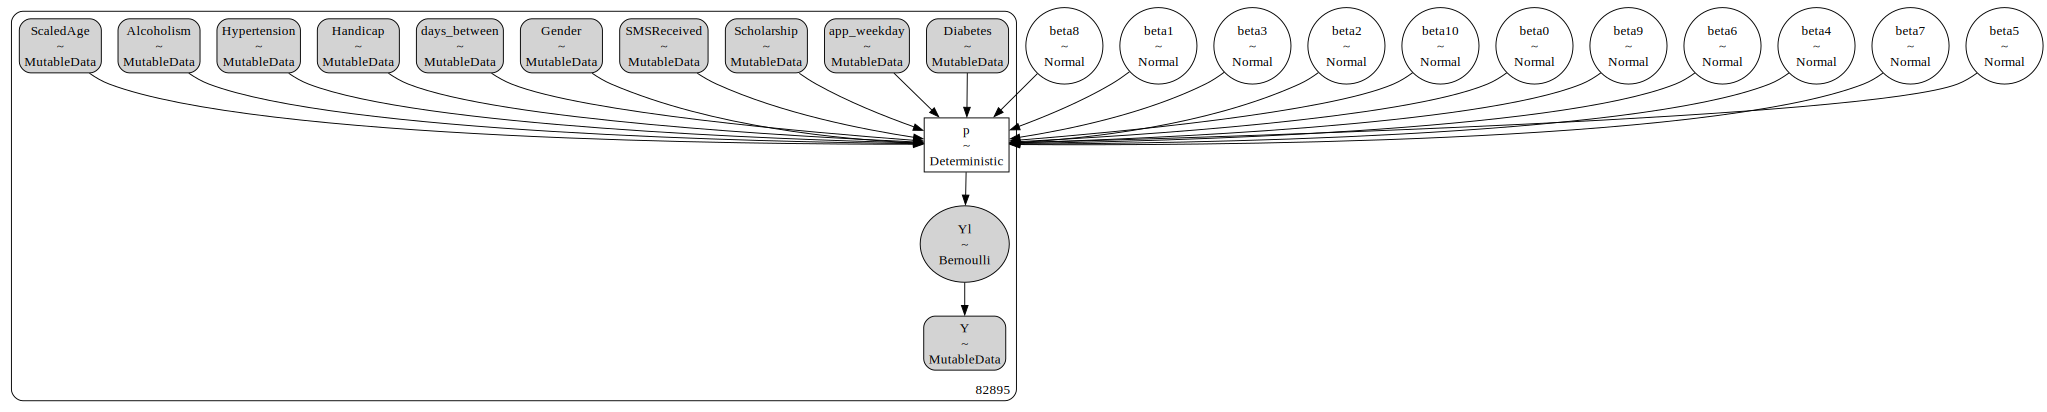

In [20]:
# Full Model

y = noshow['Noshow']

#try lowering variance term (like sigma=1)

#Creating a generalized linear model
with pm.Model() as full_glm:
    Gender = pm.MutableData('Gender', X_train['Gender'].values)
    ScaledAge = pm.MutableData('ScaledAge', X_train['ScaledAge'].values)
    Scholarship = pm.MutableData('Scholarship', X_train['Scholarship'].values)
    Hypertension = pm.MutableData('Hypertension', X_train['Hypertension'].values)
    Diabetes = pm.MutableData('Diabetes', X_train['Diabetes'].values)
    Alcoholism = pm.MutableData('Alcoholism', X_train['Alcoholism'].values)
    Handicap = pm.MutableData('Handicap', X_train['Handicap'].values)
    SMSReceived = pm.MutableData('SMSReceived', X_train['SMSReceived'].values)
    app_weekday = pm.MutableData('app_weekday', X_train['app_weekday'].values)
    days_between = pm.MutableData('days_between', X_train['days_between'].values)
    Y = pm.MutableData('Y', y_train.values)


    beta0 = pm.Normal('beta0', mu=0, sigma=1)
    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)
    beta3 = pm.Normal('beta3', mu=0, sigma=1)
    beta4 = pm.Normal('beta4', mu=0, sigma=1)
    beta5 = pm.Normal('beta5', mu=0, sigma=1)
    beta6 = pm.Normal('beta6', mu=0, sigma=1)
    beta7 = pm.Normal('beta7', mu=0, sigma=1)
    beta8 = pm.Normal('beta8', mu=0, sigma=1)
    beta9 = pm.Normal('beta9', mu=0, sigma=1)
    beta10 = pm.Normal('beta10', mu=0, sigma=5)


    mu = (beta0 + beta1*Gender + beta2*ScaledAge +
        beta3*Scholarship + beta4*Hypertension +
        beta5*Diabetes + beta6*Alcoholism  +
        beta7*Handicap  + beta8*SMSReceived +
        beta9*app_weekday + beta10*days_between)

    p = pm.Deterministic('p', pm.invlogit(mu))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)

pm.model_to_graphviz(full_glm)

## Sampling Evaluation

In [21]:
#evaluating the sampling of our glm
with full_glm:
    full_glm_trace = pm.sample(1000, tune=2000, random_seed = 100,
                               cores =8, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta0, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10]


Sampling 8 chains for 2_000 tune and 1_000 draw iterations (16_000 + 8_000 draws total) took 471 seconds.


/Users/rachelholman/anaconda3/envs/bayesml/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (82906), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'beta3'}>,
        <Axes: title={'center': 'beta3'}>],
       [<Axes: title={'center': 'beta4'}>,
        <Axes: title={'center': 'beta4'}>],
       [<Axes: title={'center': 'beta5'}>,
        <Axes: title={'center': 'beta5'}>],
       [<Axes: title={'center': 'beta6'}>,
        <Axes: title={'center': 'beta6'}>],
       [<Axes: title={'center': 'beta7'}>,
        <Axes: title={'center': 'beta7'}>],
       [<Axes: title={'center': 'beta8'}>,
        <Axes: title={'center': 'beta8'}>],
       [<Axes: title={'center': 'beta9'}>,
        <Axes: title={'center': 'beta9'}>],
       [<Axes: title={'center': 'beta10'}>,
        <Axes: title={'center': 'beta10'}>],
       [<Axes: title={'center': 'p\n0'}>,

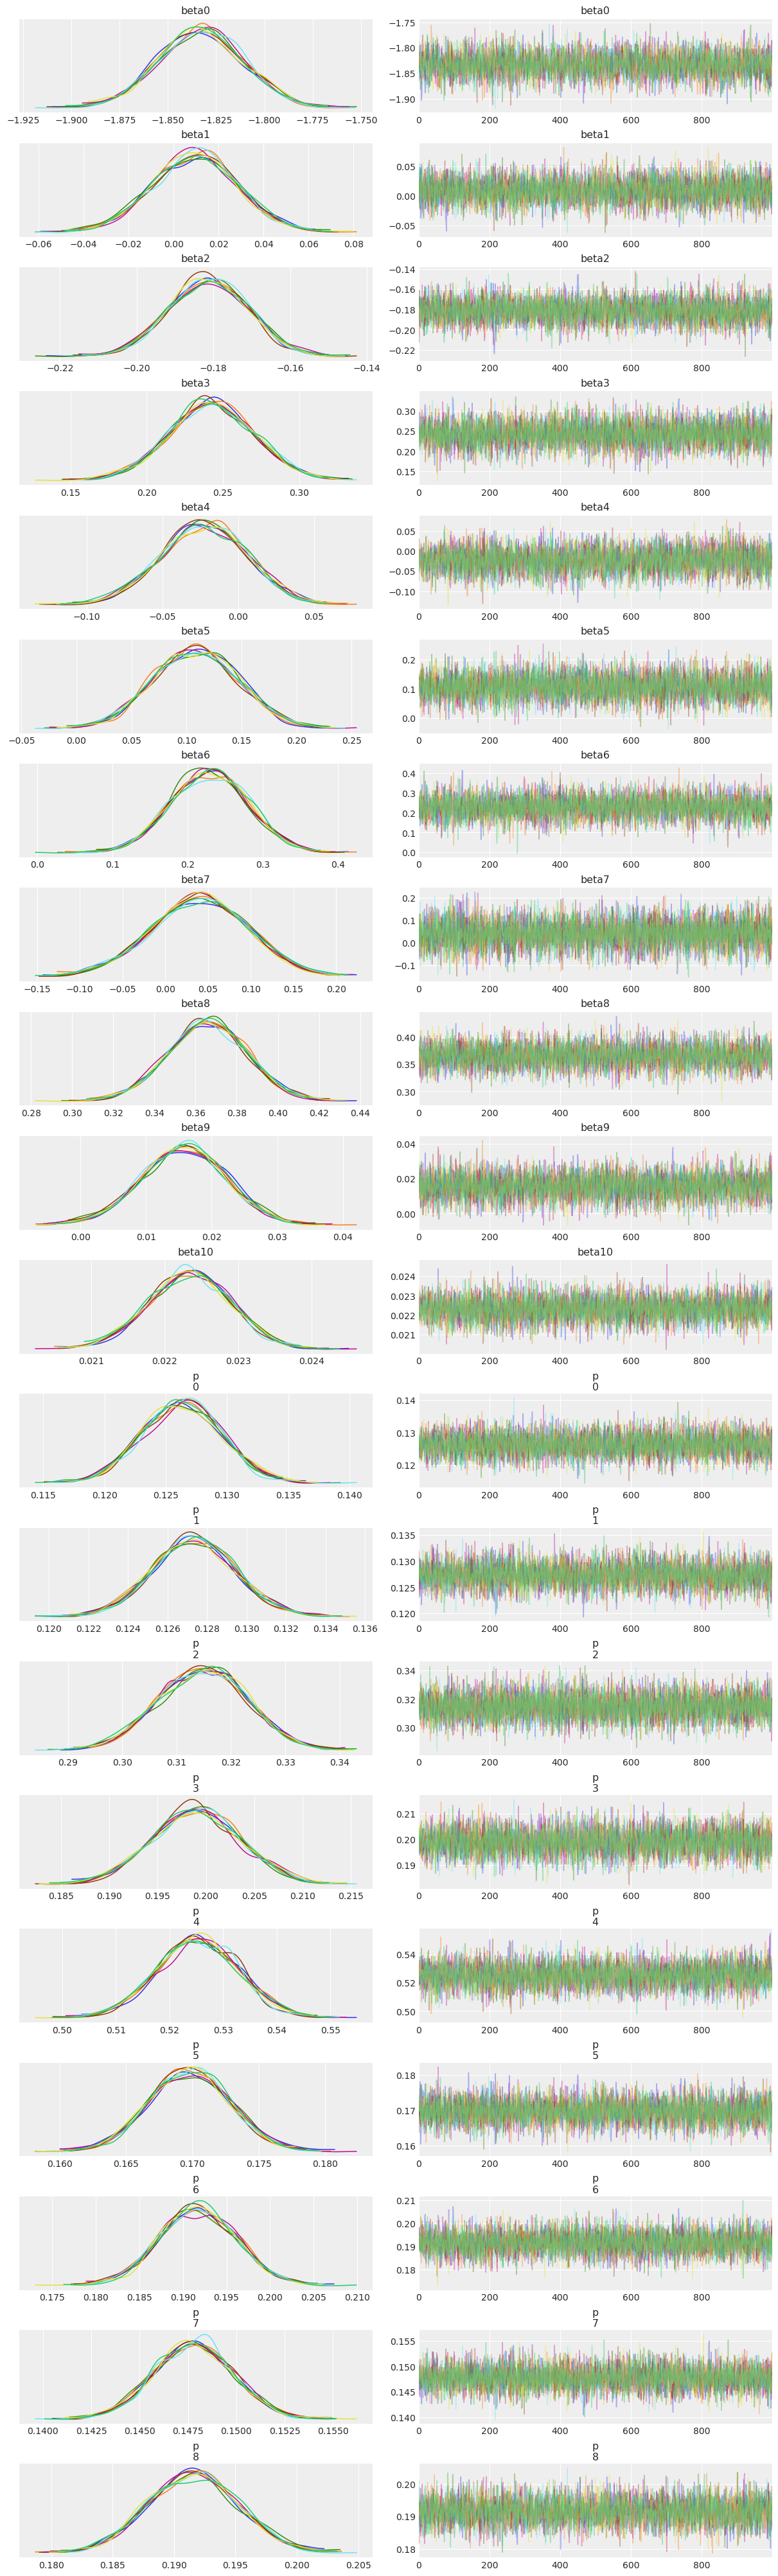

In [22]:
az.plot_trace(full_glm_trace, compact=False)

In [23]:
az.summary(full_glm_trace,
          var_names=['beta0', 'beta1', 'beta2', 'beta3', 'beta4',
                     'beta5', 'beta6', 'beta7', 'beta8', 'beta9', 'beta10'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0  -1.833  0.022  -1.875   -1.791      0.000    0.000    5399.0    5292.0   
beta1   0.009  0.019  -0.027    0.045      0.000    0.000    7233.0    5759.0   
beta2  -0.181  0.010  -0.202   -0.163      0.000    0.000    7511.0    6130.0   
beta3   0.243  0.028   0.187    0.294      0.000    0.000    8778.0    5855.0   
beta4  -0.023  0.028  -0.077    0.028      0.000    0.000    7764.0    6143.0   
beta5   0.108  0.039   0.037    0.183      0.000    0.000    8658.0    6400.0   
beta6   0.229  0.052   0.134    0.327      0.001    0.000    8194.0    6261.0   
beta7   0.040  0.057  -0.071    0.146      0.001    0.001   10143.0    5876.0   
beta8   0.366  0.019   0.330    0.402      0.000    0.000    7953.0    6499.0   
beta9   0.016  0.007   0.004    0.029      0.000    0.000    7791.0    5949.0   
beta10  0.022  0.001   0.021    0.023      0.000    0.000    8550.0    6259.0   

        r_hat  
beta0     1.0  
beta1     1.0  
beta2     1.0  
beta3     1.0  
beta4     1.0  
beta5     1.0  
beta6     1.0  
beta7     1.0  
beta8     1.0  
beta9     1.0  
beta10    1.0

In [24]:
full_glm_pp = pm.sample_posterior_predictive(full_glm_trace,
                                        model = full_glm,
                                        random_seed=100)

Sampling: [Yl]


<Axes: title={'center': 'Yl / Yl'}>

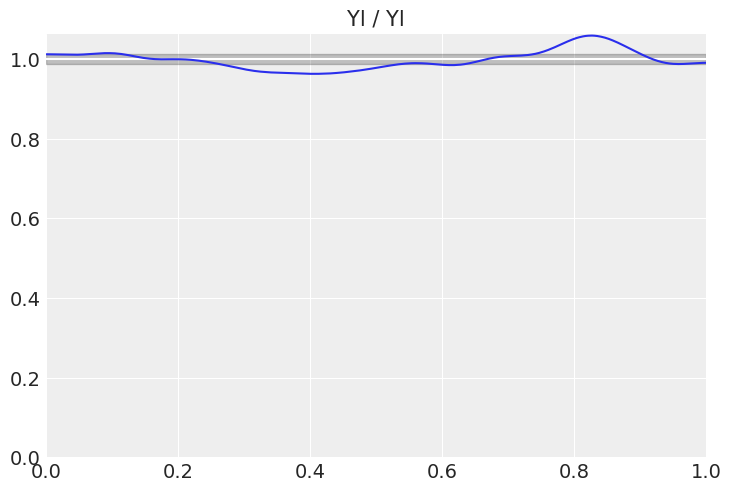

In [25]:
az.plot_bpv(full_glm_pp)

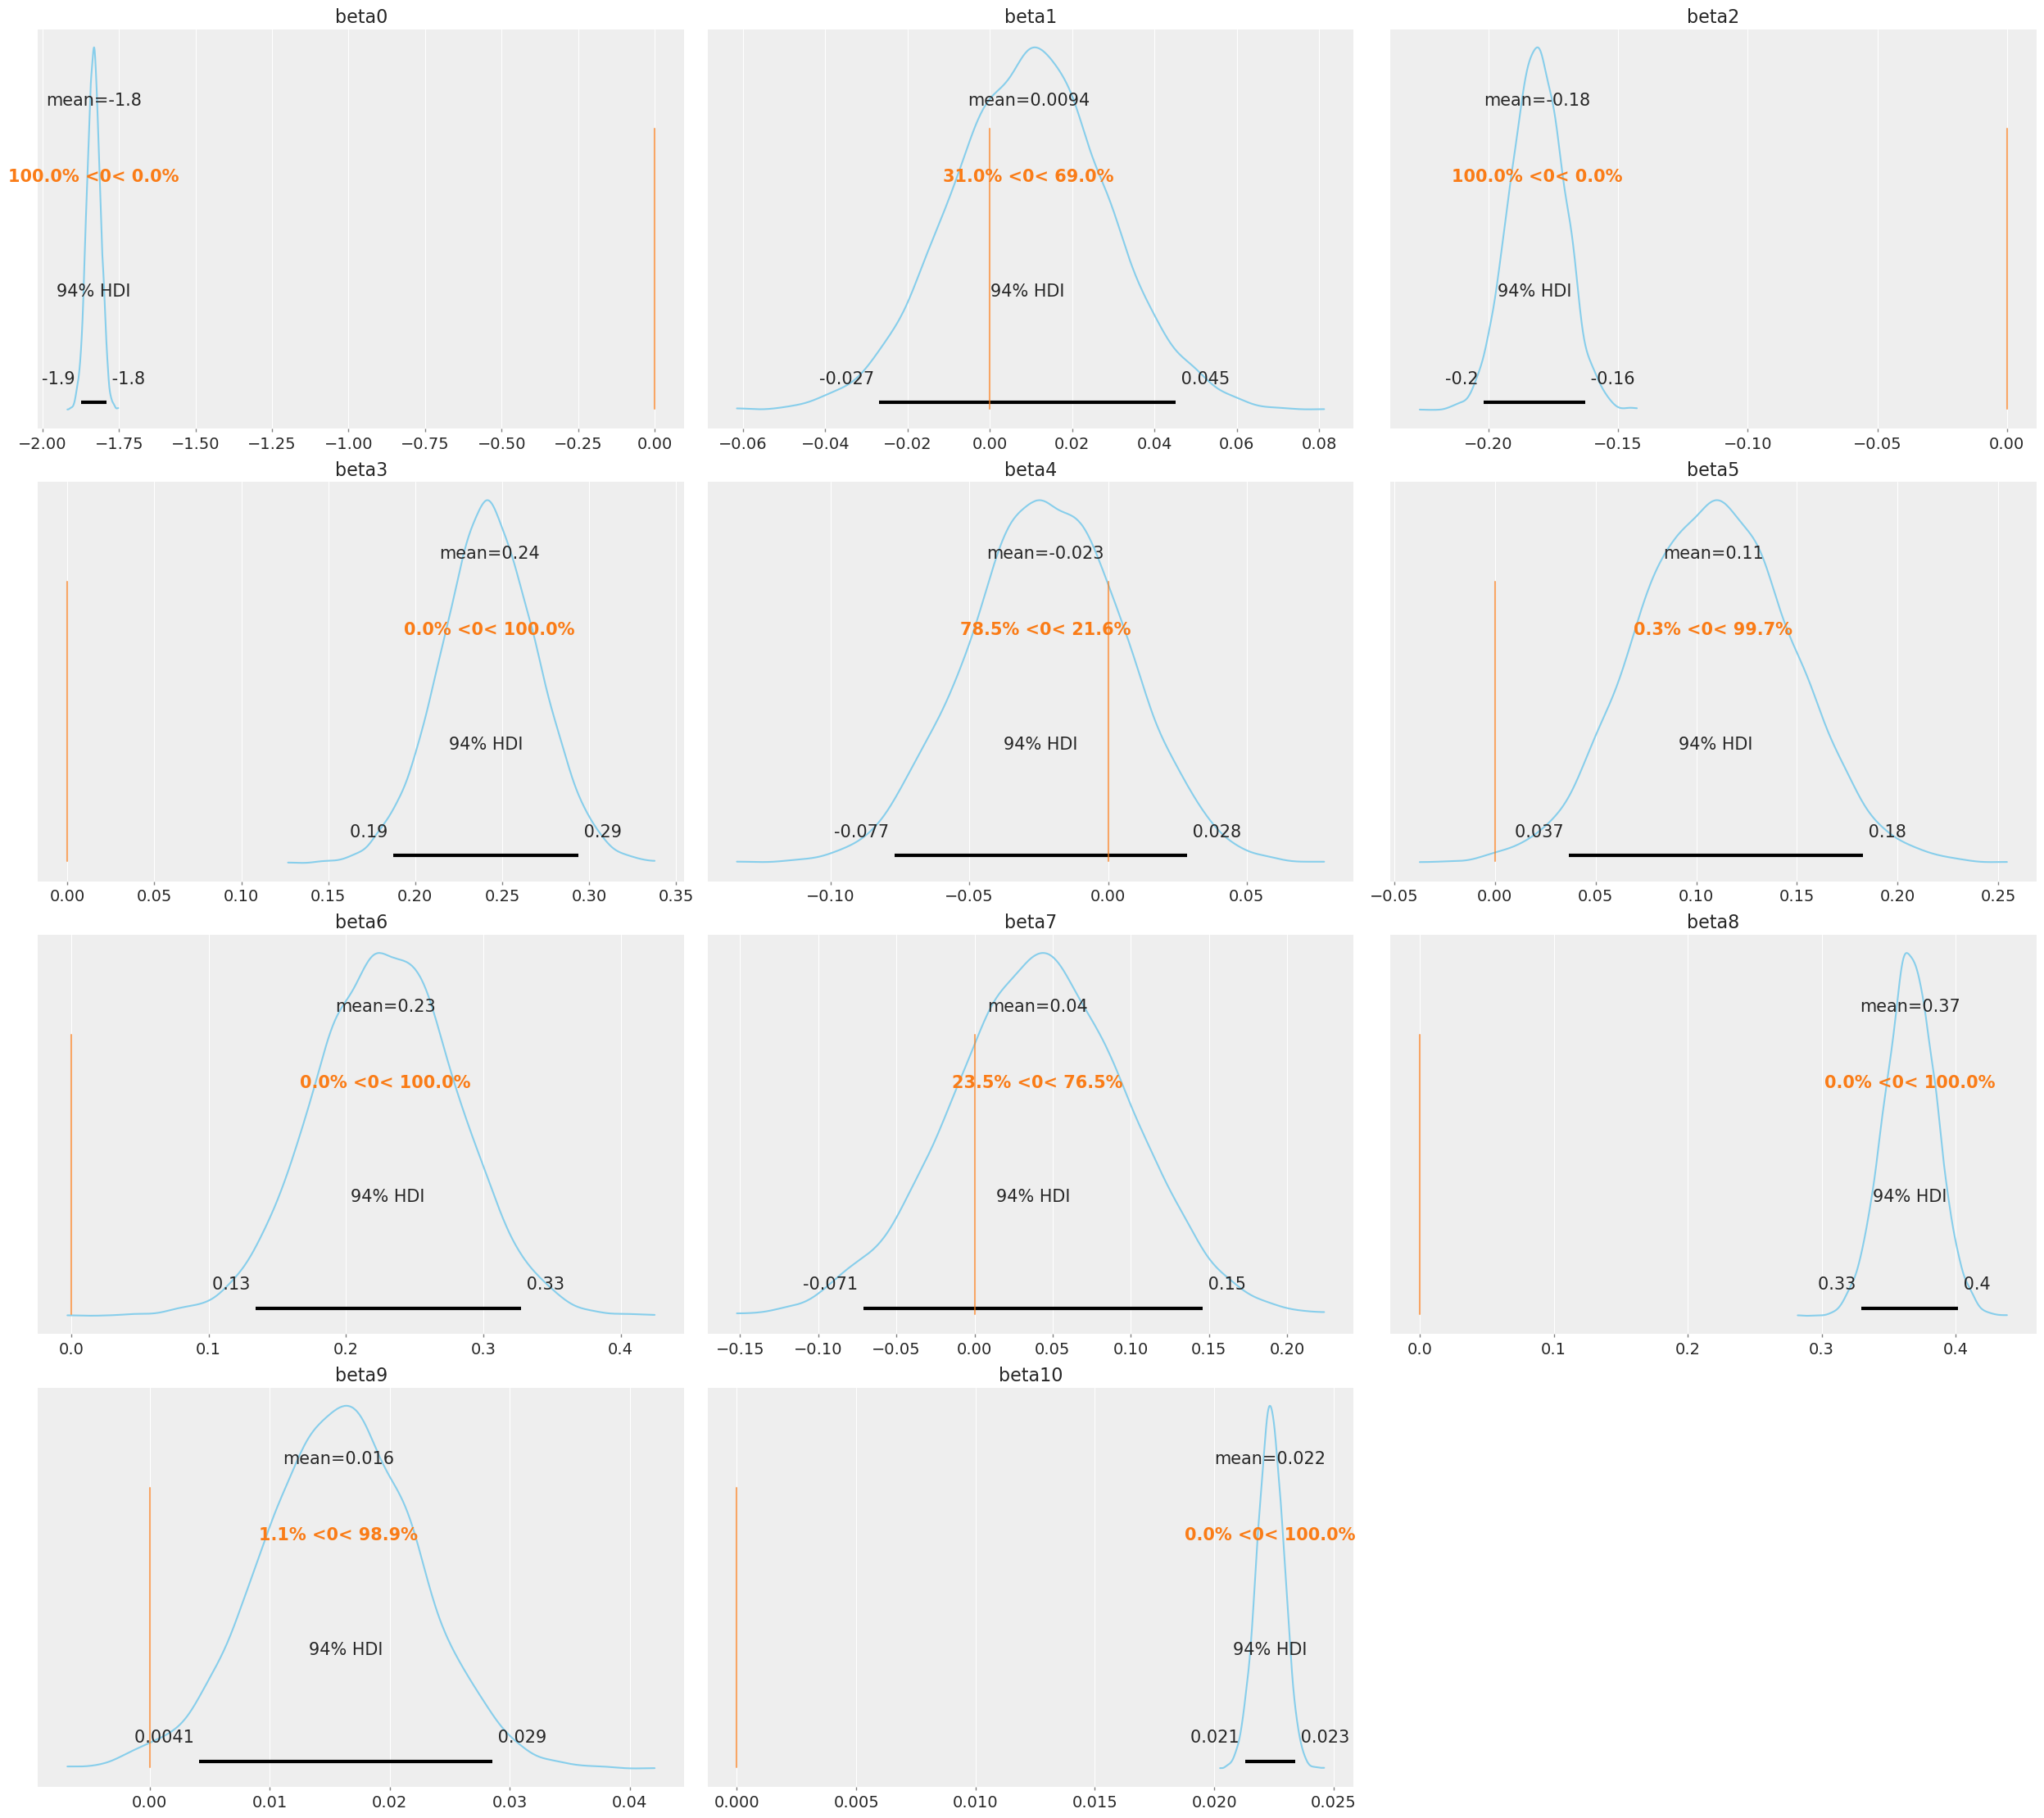

In [26]:
az.plot_posterior(
    full_glm_trace,
    var_names=['beta0', 'beta1', 'beta2', 'beta3', 'beta4',
               'beta5', 'beta6', 'beta7', 'beta8', 'beta9', 'beta10'],
    color="#87ceeb",
    ref_val = 0
);

## Reduced Model

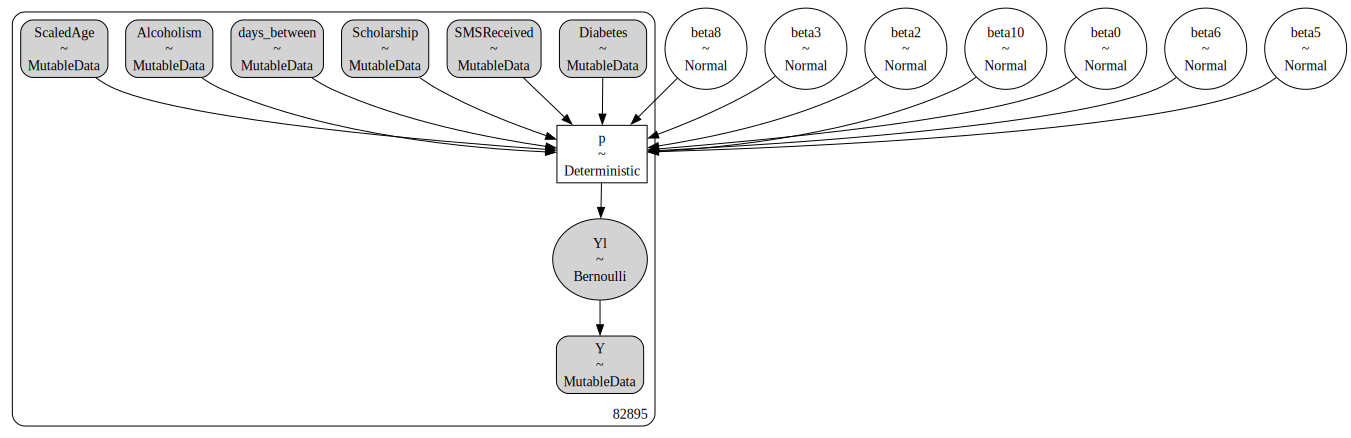

In [27]:
with pm.Model() as reduced_glm:
    ScaledAge = pm.MutableData('ScaledAge', X_train['ScaledAge'].values)
    Scholarship = pm.MutableData('Scholarship', X_train['Scholarship'].values)
    Diabetes = pm.MutableData('Diabetes', X_train['Diabetes'].values)
    Alcoholism = pm.MutableData('Alcoholism', X_train['Alcoholism'].values)
    SMSReceived = pm.MutableData('SMSReceived', X_train['SMSReceived'].values)
    days_between = pm.MutableData('days_between', X_train['days_between'].values)
    Y = pm.MutableData('Y', y_train.values)


    beta0 = pm.Normal('beta0', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)
    beta3 = pm.Normal('beta3', mu=0, sigma=1)
    beta5 = pm.Normal('beta5', mu=0, sigma=1)
    beta6 = pm.Normal('beta6', mu=0, sigma=1)
    beta8 = pm.Normal('beta8', mu=0, sigma=1)
    beta10 = pm.Normal('beta10', mu=0, sigma=5)


    mu = (beta0 + beta2*ScaledAge +
        beta3*Scholarship +
        beta5*Diabetes + beta6*Alcoholism + beta8*SMSReceived +
        beta10*days_between)

    p = pm.Deterministic('p', pm.invlogit(mu))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)

pm.model_to_graphviz(reduced_glm)

# Sampling Evaluation

In [28]:
with reduced_glm:
    reduced_glm_trace = pm.sample(1000, tune=2000, random_seed = 100,
                                  cores =8, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta0, beta2, beta3, beta5, beta6, beta8, beta10]


Sampling 8 chains for 2_000 tune and 1_000 draw iterations (16_000 + 8_000 draws total) took 212 seconds.


/Users/rachelholman/anaconda3/envs/bayesml/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (82902), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'beta3'}>,
        <Axes: title={'center': 'beta3'}>],
       [<Axes: title={'center': 'beta5'}>,
        <Axes: title={'center': 'beta5'}>],
       [<Axes: title={'center': 'beta6'}>,
        <Axes: title={'center': 'beta6'}>],
       [<Axes: title={'center': 'beta8'}>,
        <Axes: title={'center': 'beta8'}>],
       [<Axes: title={'center': 'beta10'}>,
        <Axes: title={'center': 'beta10'}>],
       [<Axes: title={'center': 'p\n0'}>,
        <Axes: title={'center': 'p\n0'}>],
       [<Axes: title={'center': 'p\n1'}>,
        <Axes: title={'center': 'p\n1'}>],
       [<Axes: title={'center': 'p\n2'}>,
        <Axes: title={'center': 'p\n2'}>],
       [<Axes: title={'center': 'p\n3'}>,
        <Axes: title={'center': 'p\n3'}>],
       [<Axes: title={'center': 'p\n4'}>,
       

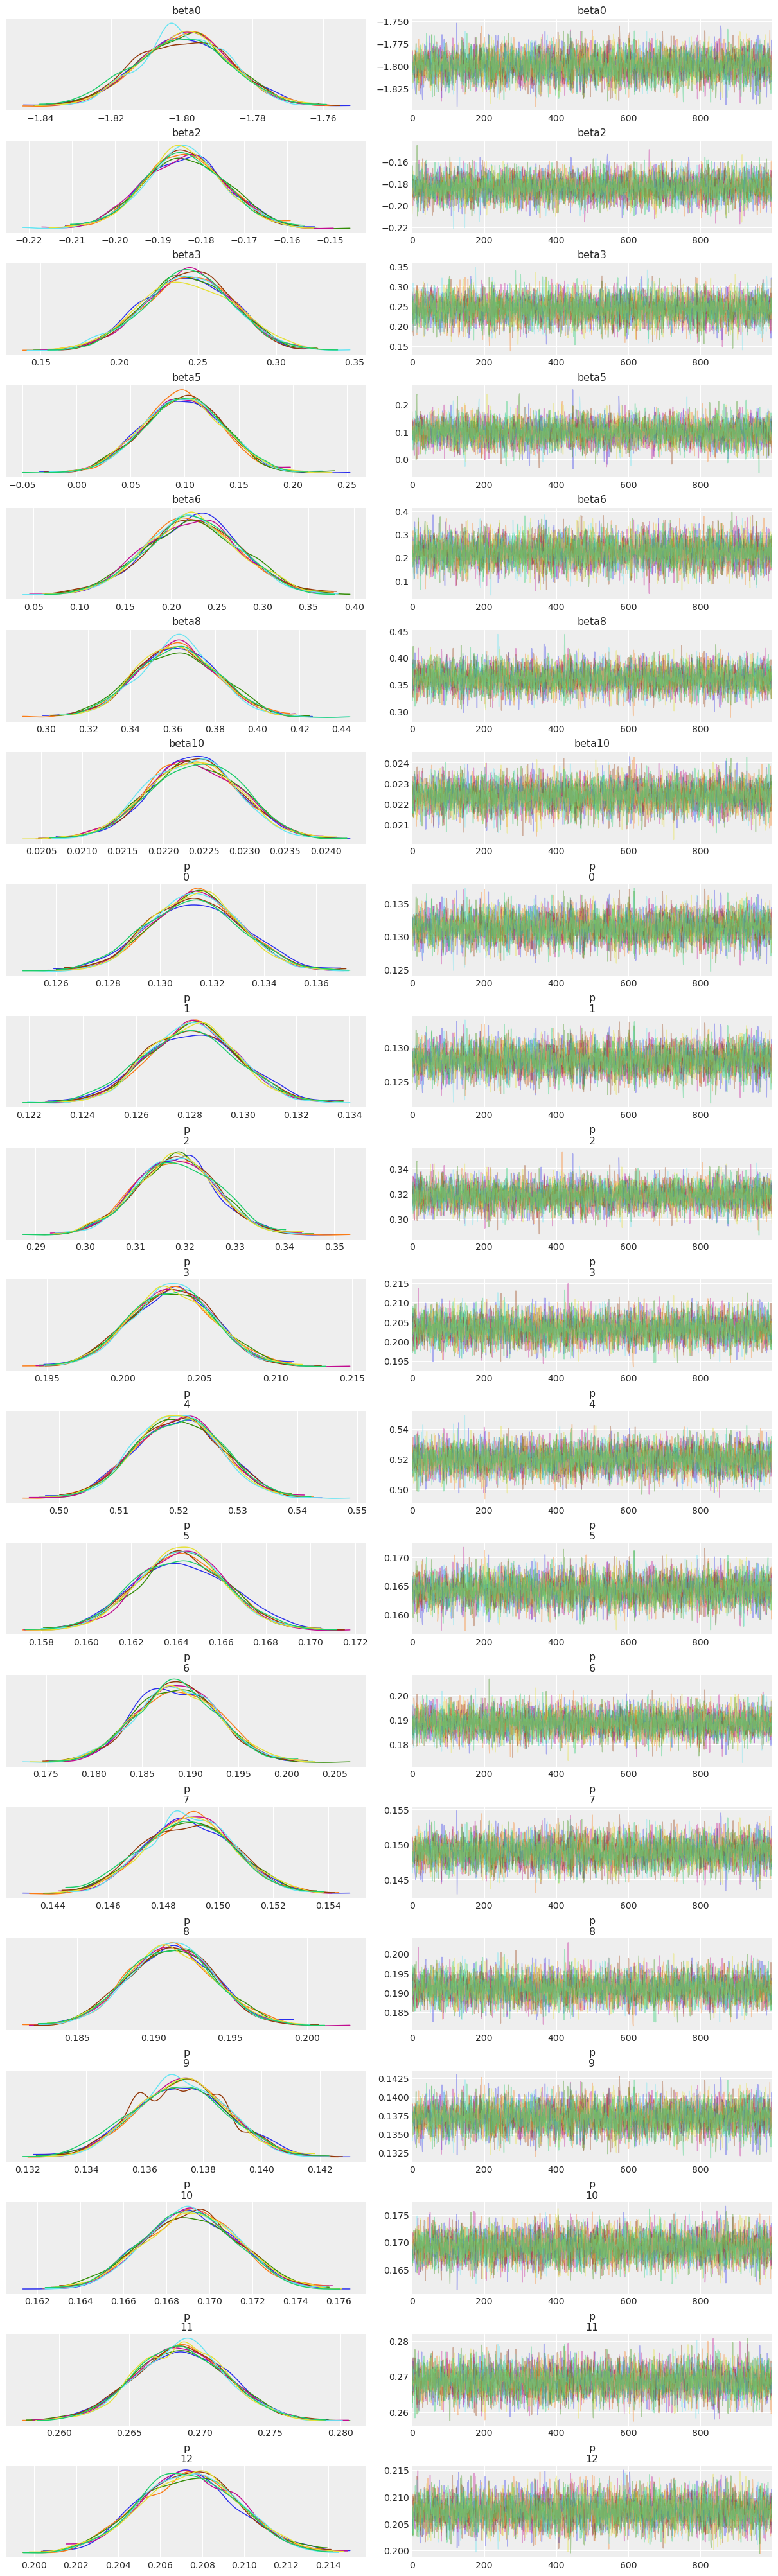

In [29]:
az.plot_trace(reduced_glm_trace, compact=False)

In [30]:
az.summary(reduced_glm_trace, var_names = ['beta0', 'beta2', 'beta3', 'beta5', 'beta6', 'beta8', 'beta10'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0  -1.799  0.013  -1.824   -1.775        0.0      0.0    9862.0    5971.0   
beta2  -0.184  0.009  -0.201   -0.166        0.0      0.0   10837.0    6876.0   
beta3   0.244  0.028   0.189    0.295        0.0      0.0   11267.0    6579.0   
beta5   0.098  0.037   0.026    0.163        0.0      0.0   10737.0    5343.0   
beta6   0.224  0.051   0.126    0.319        0.0      0.0   12794.0    6274.0   
beta8   0.362  0.019   0.328    0.401        0.0      0.0   10617.0    6211.0   
beta10  0.022  0.001   0.021    0.023        0.0      0.0   10620.0    6300.0   

        r_hat  
beta0     1.0  
beta2     1.0  
beta3     1.0  
beta5     1.0  
beta6     1.0  
beta8     1.0  
beta10    1.0

In [31]:
reduced_glm_pp = pm.sample_posterior_predictive(reduced_glm_trace,
                                        model = reduced_glm,
                                        random_seed=100)

Sampling: [Yl]


<Axes: title={'center': 'Yl / Yl'}>

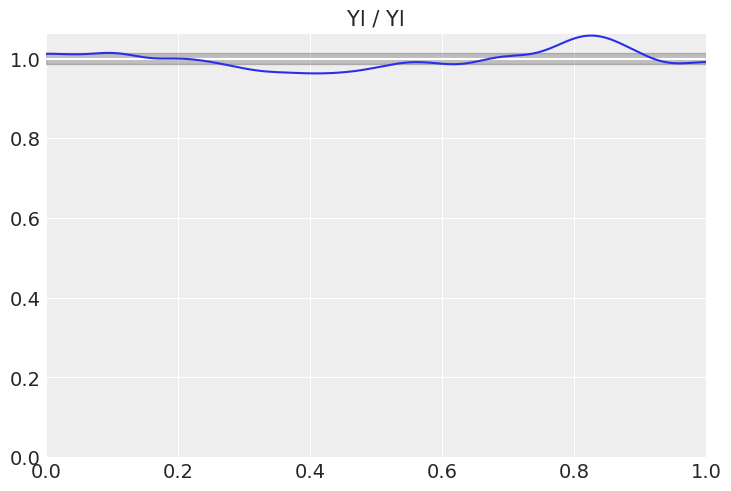

In [32]:
az.plot_bpv(reduced_glm_pp)

array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta3'}>],
       [<Axes: title={'center': 'beta5'}>,
        <Axes: title={'center': 'beta6'}>,
        <Axes: title={'center': 'beta8'}>],
       [<Axes: title={'center': 'beta10'}>, <Axes: >, <Axes: >]],
      dtype=object)

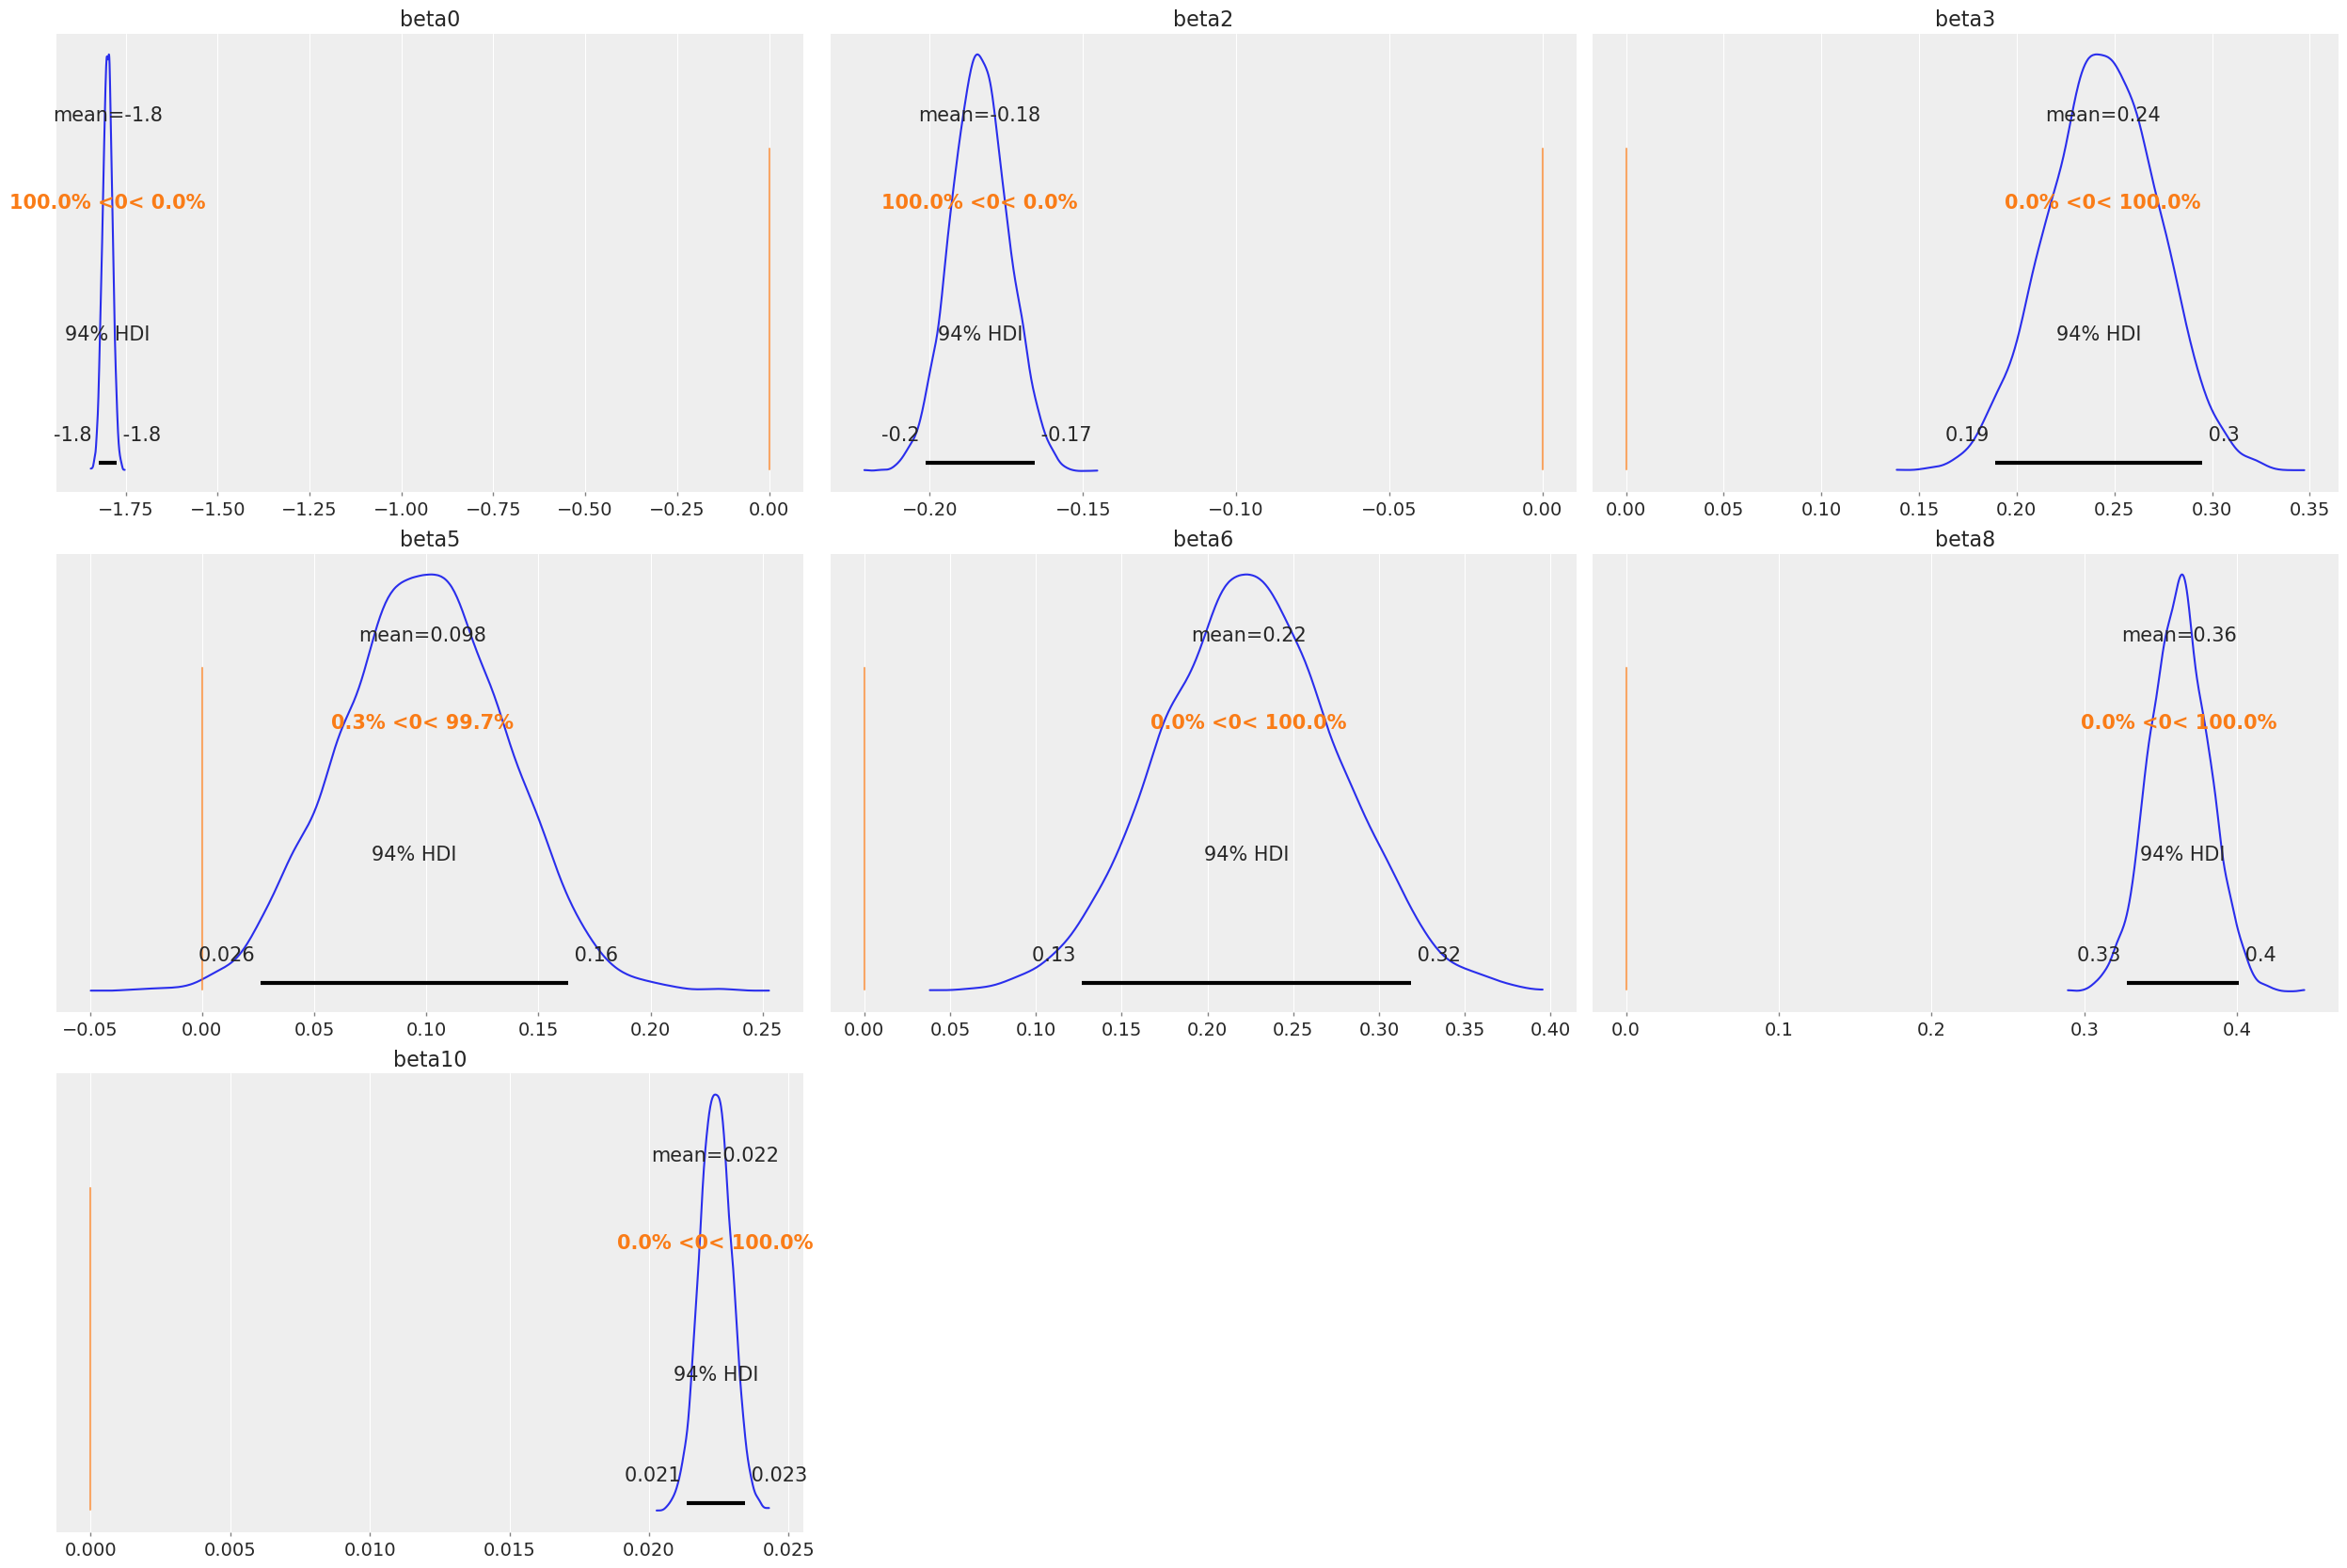

In [33]:
az.plot_posterior(reduced_glm_trace,
                  var_names = ['beta0', 'beta2', 'beta3', 'beta5', 'beta6', 'beta8', 'beta10'],
                  ref_val = 0)

# Model Evaluation

Here we compare the full and reduced model using within sample and out of sample evluation metrics.

### Within Sample Evaluation

##### Full Model Eval

In [34]:
# Full Model
#WAIC
with full_glm:
    trace = pm.sample(1000, tune=2000, random_seed = 100,
                      cores =8, return_inferencedata=False)
full_glm_trace1 = pm.to_inference_data(trace=trace,
                                       model=full_glm,
                                       log_likelihood=True)

print(az.waic(full_glm_trace1))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta0, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10]


Sampling 8 chains for 2_000 tune and 1_000 draw iterations (16_000 + 8_000 draws total) took 340 seconds.


Computed from 8000 posterior samples and 82895 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -40165.94   159.61
p_waic       11.30        -


##### Reduced Model Eval

In [35]:
# Reduced Model
#WAIC
with reduced_glm:
    trace = pm.sample(1000, tune=2000, random_seed = 100,
                      cores =8, return_inferencedata=False)
reduced_glm_trace1 = pm.to_inference_data(trace=trace,
                                       model=reduced_glm,
                                       log_likelihood=True)

print(az.waic(reduced_glm_trace1))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta0, beta2, beta3, beta5, beta6, beta8, beta10]


Sampling 8 chains for 2_000 tune and 1_000 draw iterations (16_000 + 8_000 draws total) took 146 seconds.


Computed from 8000 posterior samples and 82895 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -40165.53   159.60
p_waic        7.18        -


In [36]:
# WAIC comparison
cmp_df = az.compare({'full_glm':full_glm_trace1, 
                     'reduced_glm': reduced_glm_trace1}, ic='waic')
cmp_df

rank     elpd_waic     p_waic  elpd_diff    weight          se  \
reduced_glm     0 -40165.529339   7.177396   0.000000  0.555282  159.600184   
full_glm        1 -40165.936794  11.299102   0.407455  0.444718  159.611291   

                  dse  warning scale  
reduced_glm  0.000000    False   log  
full_glm     2.717845    False   log

### Out of Sample Evaluation

##### Full Model Eval




In [37]:
# Full Model Confusion Matrix

#making predictions on test data
with full_glm:
    pm.set_data({"Gender": X_test['Gender'].values,
               "ScaledAge": X_test['ScaledAge'].values,
               "Scholarship": X_test['Scholarship'].values,
               "Hypertension": X_test['Hypertension'].values,
               "Diabetes": X_test['Diabetes'].values,
               "Alcoholism": X_test['Alcoholism'].values,
               "Handicap": X_test['Handicap'].values,
               "SMSReceived": X_test['SMSReceived'].values,
               "app_weekday": X_test['app_weekday'].values,
               "days_between": X_test['days_between'].values,
                "Y":np.zeros_like(y_test.values)})

    full_ppc = pm.sample_posterior_predictive(full_glm_trace,
                                         return_inferencedata = True,
                                         predictions=True,
                                         random_seed=100)

# compute y_score
with full_glm:
    full_y_score = full_ppc.predictions['Yl'].mean(dim=["chain", "draw"])

from sklearn.metrics import *

#convert y_score into binary decisions
full_model_prediction=[1 if x >0.5 else 0 for x in full_y_score]
#compute confussion matrix
full_model_confussion_matrix =confusion_matrix(y_test, full_model_prediction)
full_model_confussion_matrix

Sampling: [Yl]


array([[21916,   172],
       [ 5464,    80]])

In [38]:
#creating function for plotting ROC curves
def plot_roc(y_true, y_pred):
    fpr, tpr, thresh = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()

In [39]:
#ROC curve for full model
roc_auc_score(y_test, full_model_prediction)

0.5033214903732832

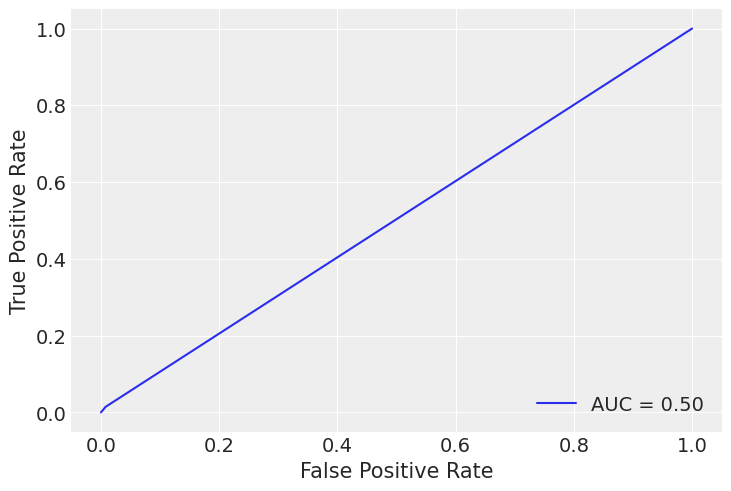

In [40]:
plot_roc(y_test, full_model_prediction)

##### Reduced Model Eval


In [41]:
# Full Model Confusion Matrix

#making predictions on test data
with reduced_glm:
    pm.set_data({"ScaledAge": X_test['ScaledAge'].values,
               "Scholarship": X_test['Scholarship'].values,
               "Diabetes": X_test['Diabetes'].values,
               "Alcoholism": X_test['Alcoholism'].values,
               "SMSReceived": X_test['SMSReceived'].values,
               "days_between": X_test['days_between'].values,
                "Y":np.zeros_like(y_test.values)})

    reduced_ppc = pm.sample_posterior_predictive(reduced_glm_trace,
                                         return_inferencedata = True,
                                         predictions=True,
                                         random_seed=100)

# compute y_score
with reduced_glm:
    reduced_y_score = reduced_ppc.predictions['Yl'].mean(dim=["chain", "draw"])

from sklearn.metrics import *

#convert y_score into binary decisions
reduced_model_prediction=[1 if x >0.5 else 0 for x in reduced_y_score]
#compute confussion matrix
reduced_model_confussion_matrix =confusion_matrix(y_test, reduced_model_prediction)
reduced_model_confussion_matrix

Sampling: [Yl]


array([[21918,   170],
       [ 5460,    84]])

In [42]:
#creating function for plotting ROC curves
def plot_roc(y_true, y_pred):
    fpr, tpr, thresh = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()

In [43]:
#ROC curve for full model
roc_auc_score(y_test, reduced_model_prediction)

0.5037275141856815

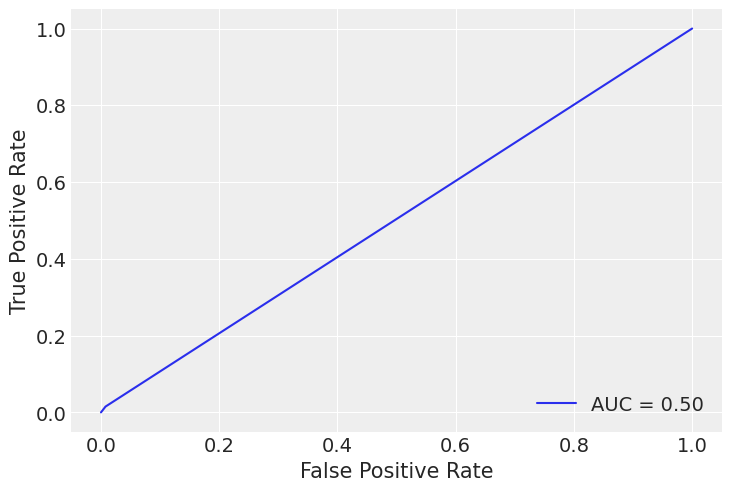

In [44]:
plot_roc(y_test, reduced_model_prediction)

# Under-Sampling to Rebalance Classes

(to try and improve performance)

In [45]:
# Under-Sampling
from imblearn.under_sampling import EditedNearestNeighbours

x_res, y_res = EditedNearestNeighbours().fit_resample(X_train, y_train)

In [46]:
# Running the model trace again
with reduced_glm:
    pm.set_data({"ScaledAge": x_res['ScaledAge'].values,
                 "Scholarship": x_res['Scholarship'].values,
                 "Diabetes": x_res['Diabetes'].values,
                 "Alcoholism": x_res['Alcoholism'].values,
                 "SMSReceived": x_res['SMSReceived'].values,
                 "days_between": x_res['days_between'].values,
                 "Y":y_res})

    reduced_trace_resample = pm.sample(1000, tune=2000, random_seed = 100,
                       cores =8, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta0, beta2, beta3, beta5, beta6, beta8, beta10]


Sampling 8 chains for 2_000 tune and 1_000 draw iterations (16_000 + 8_000 draws total) took 110 seconds.


In [47]:
# Making predictions
with reduced_glm:
    pm.set_data({"ScaledAge": X_test['ScaledAge'].values,
               "Scholarship": X_test['Scholarship'].values,
               "Diabetes": X_test['Diabetes'].values,
               "Alcoholism": X_test['Alcoholism'].values,
               "SMSReceived": X_test['SMSReceived'].values,
               "days_between": X_test['days_between'].values,
                "Y":np.zeros_like(y_test.values)})

    reduced_ppc_resamp = pm.sample_posterior_predictive(reduced_trace_resample,
                                         return_inferencedata = True,
                                         predictions=True,
                                         random_seed=100)

Sampling: [Yl]


In [48]:
# Using ROC to assess performance
# compute y_score
with reduced_glm:
    reduced_y_score = reduced_ppc_resamp.predictions['Yl'].mean(dim=["chain", "draw"])

#convert y_score into binary decisions
reduced_model_prediction_resamp=[1 if x >0.5 else 0 for x in reduced_y_score]

#compute confussion matrix
reduced_model_confussion_matrix =confusion_matrix(y_test, reduced_model_prediction_resamp)
reduced_model_confussion_matrix

array([[19539,  2549],
       [ 4259,  1285]])

In [49]:
# Computing the AUC
roc_auc_score(y_test, reduced_model_prediction_resamp)

0.5581900392657365

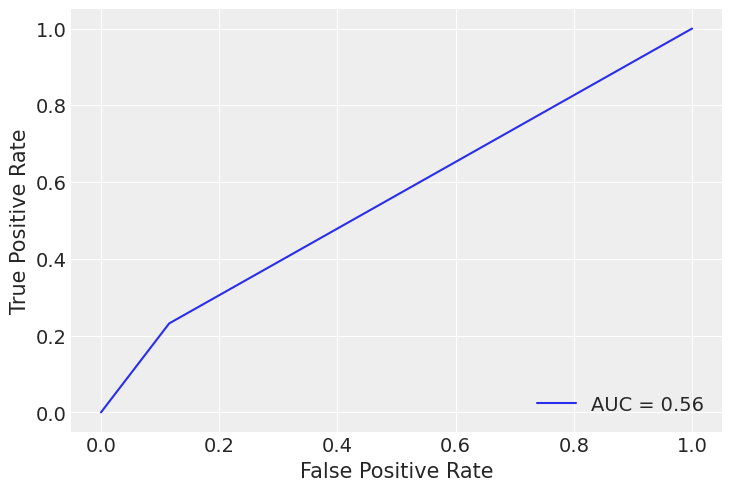

In [50]:
# Plotting the ROC curve
plot_roc(y_test, reduced_model_prediction_resamp)

# Transforming Predictor Variables

(to try and improve performance)

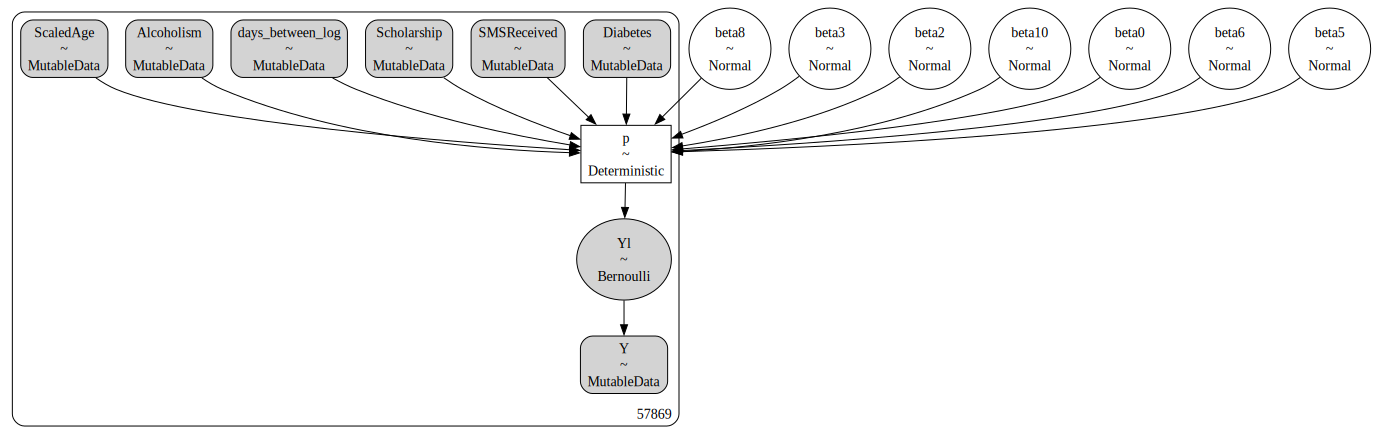

In [51]:
# Using the transformed predictor variable 'days_between_log' in the new model
with pm.Model() as transformed_glm:
    ScaledAge = pm.MutableData('ScaledAge', x_res['ScaledAge'].values)
    Scholarship = pm.MutableData('Scholarship', x_res['Scholarship'].values)
    Diabetes = pm.MutableData('Diabetes', x_res['Diabetes'].values)
    Alcoholism = pm.MutableData('Alcoholism', x_res['Alcoholism'].values)
    SMSReceived = pm.MutableData('SMSReceived', x_res['SMSReceived'].values)
    days_between_log = pm.MutableData('days_between_log', x_res['days_between_log'].values)
    Y = pm.MutableData('Y', y_res.values)


    beta0 = pm.Normal('beta0', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)
    beta3 = pm.Normal('beta3', mu=0, sigma=1)
    beta5 = pm.Normal('beta5', mu=0, sigma=1)
    beta6 = pm.Normal('beta6', mu=0, sigma=1)
    beta8 = pm.Normal('beta8', mu=0, sigma=1)
    beta10 = pm.Normal('beta10', mu=0, sigma=1)


    mu = (beta0 + beta2*ScaledAge +
        beta3*Scholarship +
        beta5*Diabetes + beta6*Alcoholism + beta8*SMSReceived +
        beta10*days_between_log)

    p = pm.Deterministic('p', pm.invlogit(mu))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)

pm.model_to_graphviz(transformed_glm)


In [52]:
# transformed Model Confusion Matrix
#creating new trace
with transformed_glm:
    trace3 = pm.sample(1000, tune=2000, random_seed = 100,
                       cores =8, init='adapt_diag')

#making predictions on test data
with transformed_glm:
    pm.set_data({"ScaledAge": X_test['ScaledAge'].values,
               "Scholarship": X_test['Scholarship'].values,
               "Diabetes": X_test['Diabetes'].values,
               "Alcoholism": X_test['Alcoholism'].values,
               "SMSReceived": X_test['SMSReceived'].values,
               "days_between_log": X_test['days_between_log'].values,
                "Y":np.zeros_like(y_test.values)})

    transformed_ppc = pm.sample_posterior_predictive(trace3,
                                         return_inferencedata = True,
                                         predictions=True,
                                         random_seed=100)

# compute y_score
with transformed_glm:
    transformed_y_score = transformed_ppc.predictions['Yl'].mean(dim=["chain", "draw"])

from sklearn.metrics import *

#convert y_score into binary decisions
transformed_model_prediction=[1 if x >0.5 else 0 for x in transformed_y_score]

#compute confussion matrix
transformed_model_confussion_matrix =confusion_matrix(y_test, transformed_model_prediction)
transformed_model_confussion_matrix

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta0, beta2, beta3, beta5, beta6, beta8, beta10]


Sampling 8 chains for 2_000 tune and 1_000 draw iterations (16_000 + 8_000 draws total) took 98 seconds.
Sampling: [Yl]


array([[17430,  4658],
       [ 3130,  2414]])

In [53]:
# Computing the AUC
roc_auc_score(y_test, transformed_model_prediction)

0.6122709738247587

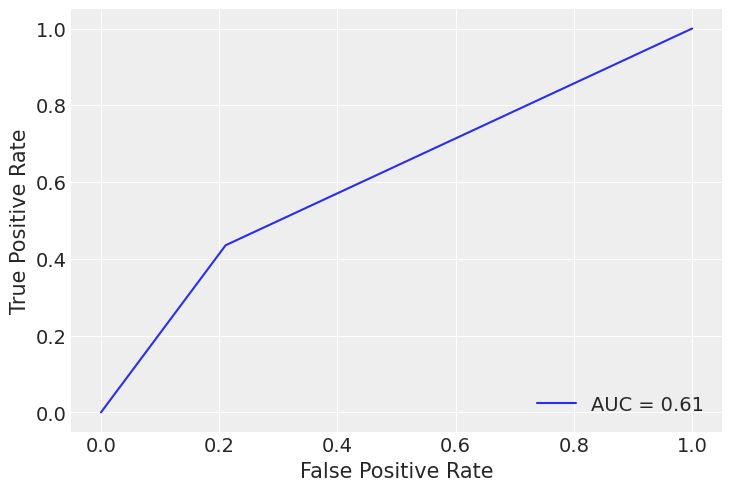

In [54]:
# Plotting the ROC curve
plot_roc(y_test, transformed_model_prediction)

Sampling: [Yl]


<Axes: xlabel='Yl / Yl'>

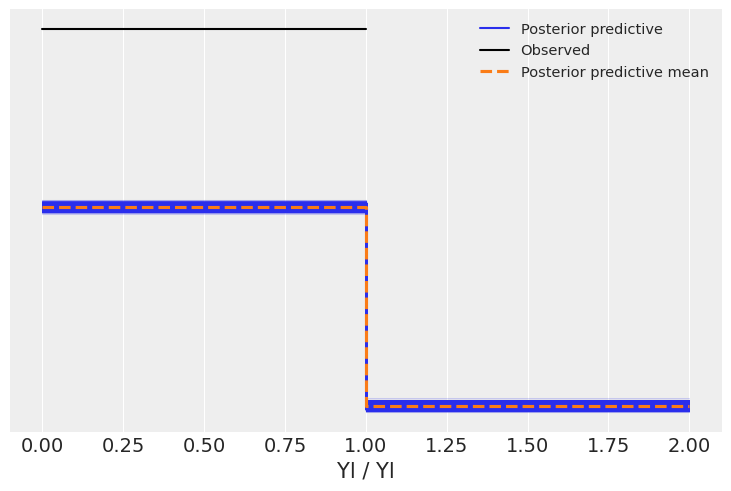

In [55]:
# Plotting PPC
#plotting the posterior predictions

transformed_pp = pm.sample_posterior_predictive(trace3, model = transformed_glm, random_seed = 100)
az.plot_ppc(transformed_pp)

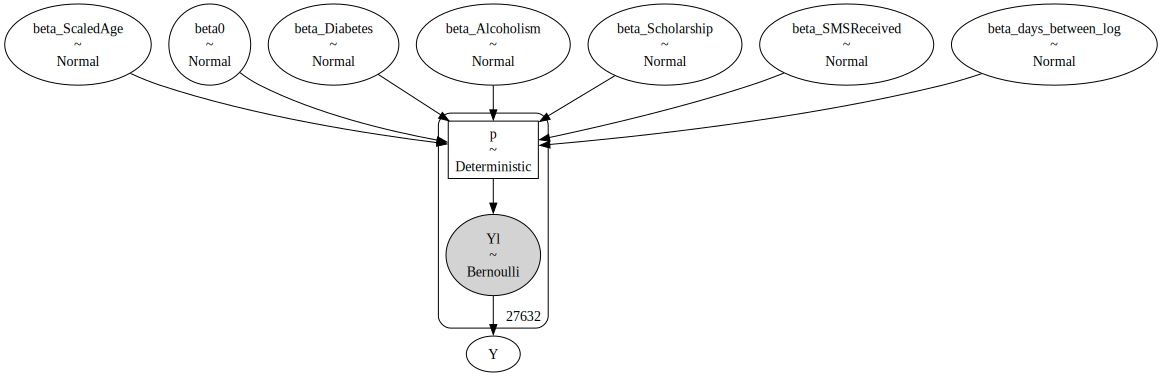

In [56]:
# Final model visualization
with pm.Model() as transformed_glm:
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta2 = pm.Normal('beta_ScaledAge', mu=0, sigma=10)
    beta3 = pm.Normal('beta_Scholarship', mu=0, sigma=10)
    beta5 = pm.Normal('beta_Diabetes', mu=0, sigma=10)
    beta6 = pm.Normal('beta_Alcoholism', mu=0, sigma=10)
    beta8 = pm.Normal('beta_SMSReceived', mu=0, sigma=10)
    beta10 = pm.Normal('beta_days_between_log', mu=0, sigma=10)


    mu = (beta0 + beta2*ScaledAge +
        beta3*Scholarship +
        beta5*Diabetes + beta6*Alcoholism + beta8*SMSReceived +
        beta10*days_between_log)

    p = pm.Deterministic('p', pm.invlogit(mu))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)

pm.model_to_graphviz(transformed_glm)